#### Going to train a full redshift flow for the rail forward modeling

In [1]:
import numpy as onp
import jax.numpy as np
import matplotlib.pyplot as plt
import corner
import pandas as pd

import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
from pzflow.distributions import Joint, Normal, Uniform

In [2]:
# plotting style
plt.style.use('../paper.mplstyle')
twocol = 7.1014
onecol = 3.35

#### Load the DC2 data

In [3]:
data = pd.read_pickle("dc2.pkl")
# select a subset and cut out ra & dec
data = data.iloc[:1000000, 2:]
# print some of the data
data

,redshift,u,g,r,i,z,y
0,2.008235,27.136230,26.670242,26.667273,26.582212,26.357750,26.152222
1,0.978697,27.316854,27.212221,26.671032,25.900785,25.353924,25.256409
2,1.141199,27.646139,27.523197,27.239439,26.955040,26.153460,26.039215
3,0.380182,30.007523,28.263083,26.901390,26.366058,26.075935,25.875998
4,1.215204,25.069988,25.117722,25.167130,25.186823,24.732811,24.613487
...,...,...,...,...,...,...,...
999995,2.395404,28.358000,27.508904,27.257092,27.326817,27.170570,27.028576
999996,0.915248,25.462215,25.123844,24.359940,23.329554,22.892763,22.825127
999997,1.398047,27.489780,27.503931,27.583220,27.555323,27.463623,26.960890
999998,1.299518,26.708790,26.492617,26.126745,25.646049,25.030140,24.421446


#### Create a flow to model the data

In [4]:
# set the Color Transform reference index
# to use the r band as the reference magnitude
ref_idx = data.columns.get_loc("r")
# set the column indices for the magnitudes we want colors from
mag_idx = [data.columns.get_loc(col) for col in ["u","g","r","i","z","y"]]

# set the inverse softplus parameters, 
# to ensure that sampled redshifts are positive
column_idx = 0
sharpness = 10

# calculate the mean and standard deviations of the dimensions
# note that on this side of the color transform, we are working
# in color space, so I calculate the mean and std dev of these 
# variables instead of the raw magnitudes
data_temp = np.array([data['redshift'], 
                      data['r'], 
                      data['u'] - data['g'], 
                      data['g'] - data['r'], 
                      data['r'] - data['i'], 
                      data['i'] - data['z'], 
                      data['z'] - data['y']]).T

means = data_temp.mean(axis=0)
stds = data_temp.std(axis=0)
del data_temp

# set number of layers in the RollingSplineCoupling
# equal to the input dimension
nlayers = data.shape[1]

# construct our bijector
# by chaining all these layers
bijector = Chain(
    ColorTransform(ref_idx, mag_idx),
    InvSoftplus(column_idx, sharpness),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers, K=2, transformed_dim=1, B=5),
)

flow = Flow(data.columns, bijector)

#### Train the flow

In [5]:
%%time
losses = flow.train(data, epochs=200, verbose=True)

Training 200 epochs 
Loss:
11.1045
-5.0604
-7.5491
-7.7547
-8.1613
-8.2924
-8.3767
-8.5304
-8.6497
-8.5561
-8.6576
-8.7415
-8.7412
-8.8150
-8.7341
-8.7128
-8.9018
-8.7810
-8.9663
-8.9315
-8.9233
CPU times: user 38min 23s, sys: 15min 2s, total: 53min 25s
Wall time: 31min 20s


Print validation loss
#### NOTE THERE IS NO VALIDATION DATA. NEED TO FIX THIS

In [ ]:
validation_data = pd.read_pickle("dc2.pkl").iloc[1000000:, 2:]
print(f"Validation data: {flow.log_prob(validation_data).mean()}")

#### Plot the results

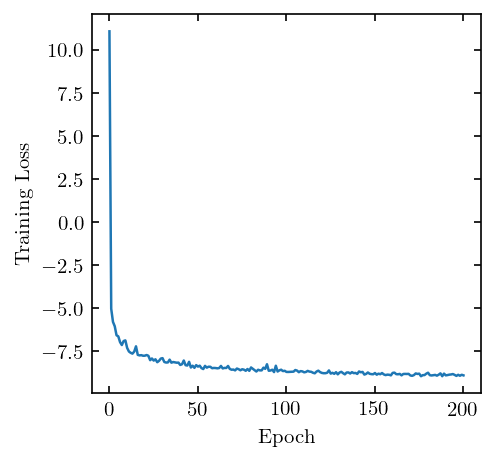

In [8]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

In [9]:
samples = flow.sample(10000, seed=0)

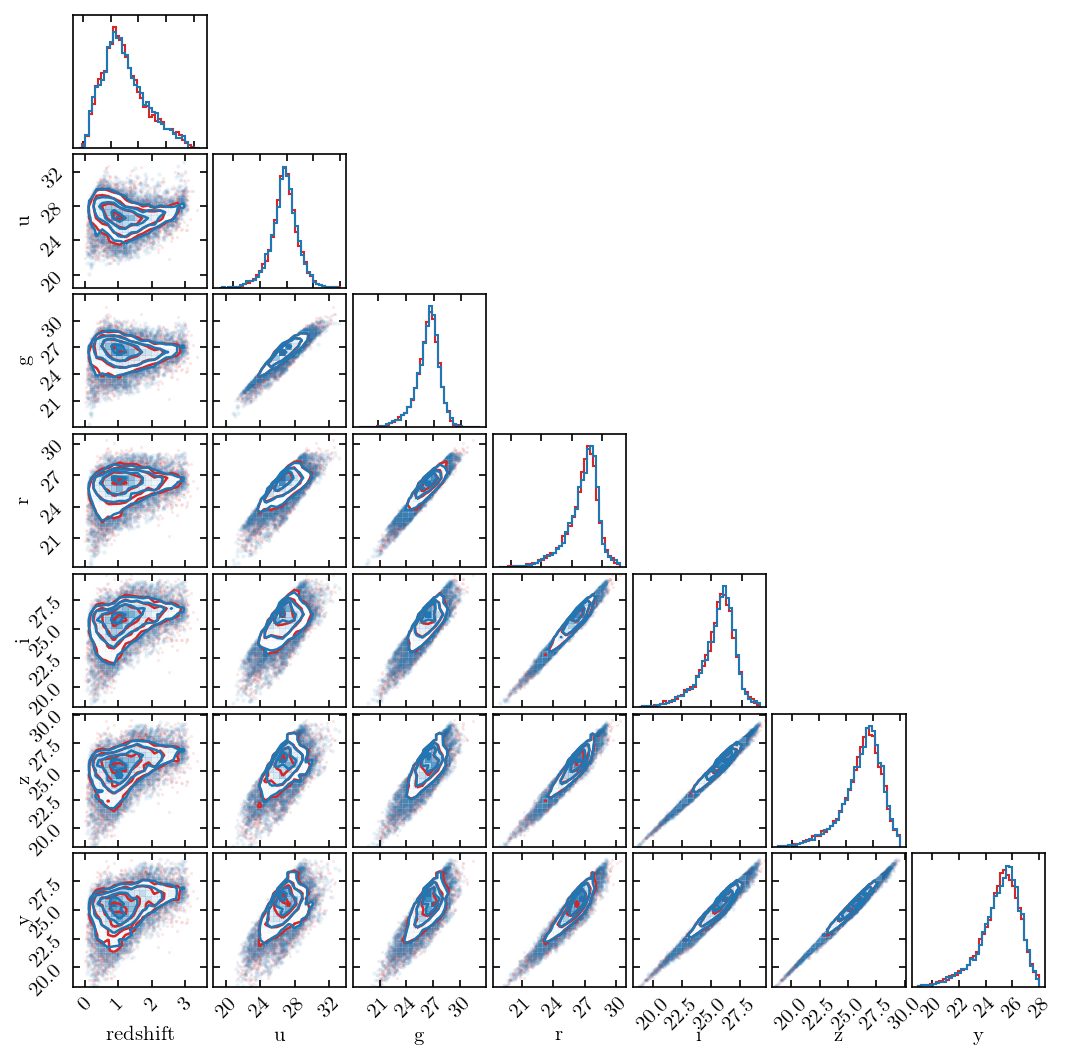

In [10]:
fig = plt.figure(figsize=(twocol, twocol))

ranges = [(-0.1,3.4), (19.5,33), (19,32), (19,29), (19,29), (19,28), (19,28)]

corner.corner(samples, fig=fig, color='C3', bins=20, range=ranges, hist_bin_factor=2, data_kwargs={'ms':1.5})

corner.corner(data[:10000], fig=fig, bins=20, range=ranges, hist_bin_factor=2, color='C0',
              labels=["redshift", "u", "g", "r", "i", "z", "y"])

fig.savefig("figures/flow-corner.pdf")

#### Save the flow

In [12]:
flow.info = f"""
Flow for the forward model section of the pzflow paper.
Trained on a million galaxies from DESC DC2 DR6.

This flow was created with pzflow version {pzflow.__version__}
"""

In [13]:
flow.save("saved-flows/desc-dc2-dr6-redshift-flow.pkl")